In [ ]:
import tensorflow as tf
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
import sys
import numpy as np
import random
from PIL import Image
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Input, Conv2D, Activation, Flatten, Dense, MaxPooling2D, BatchNormalization, Dropout, MaxPool2D, GlobalAveragePooling2D, Reshape, Lambda, GlobalMaxPooling2D
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from scipy.spatial import distance
import tensorflow.keras.backend
import seaborn as sns
from keras.regularizers import l2
from PIL import Image, ImageOps
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
from google.colab import drive

drive.mount('/content/Drive')

Mounted at /content/Drive


In [ ]:
!unzip /content/Drive/MyDrive/MachineLearning/train_resized_128.zip -d /Data/

Streaming output truncated to the last 5000 lines.
  inflating: /Data/train_resized_128/ae5aa5cda.jpg  
  inflating: /Data/train_resized_128/ae5b52ae0.jpg  
  inflating: /Data/train_resized_128/ae5f8dc8b.jpg  
  inflating: /Data/train_resized_128/ae6a32539.jpg  
  inflating: /Data/train_resized_128/ae6a5dcfc.jpg  
  inflating: /Data/train_resized_128/ae6e57b9c.jpg  
  inflating: /Data/train_resized_128/ae7993c1d.jpg  
  inflating: /Data/train_resized_128/ae7e16db8.jpg  
  inflating: /Data/train_resized_128/ae8897f8d.jpg  
  inflating: /Data/train_resized_128/ae8949a6f.jpg  
  inflating: /Data/train_resized_128/ae8ab0e36.jpg  
  inflating: /Data/train_resized_128/ae9010d64.jpg  
  inflating: /Data/train_resized_128/ae923f461.jpg  
  inflating: /Data/train_resized_128/ae95ccfad.jpg  
  inflating: /Data/train_resized_128/ae99a2d7a.jpg  
  inflating: /Data/train_resized_128/ae9d22e9d.jpg  
  inflating: /Data/train_resized_128/aea0bd5b2.jpg  
  inflating: /Data/train_resized_128/aea5730d8.j

In [ ]:
#creating train images and labels data set
train_csv = pd.read_csv("/Data/train.csv")
train_data = train_csv.values.tolist()

#create dict for train image names and labels
train_image_names = {}
for el in train_data:
    img_name = el[0]
    train_label = el[1]
    if train_label != 'new_whale':
        if train_label not in train_image_names:
            train_image_names[train_label] = [img_name]
        else:
            temp = train_image_names[train_label]
            if len(temp) > 10:
                continue
            temp.append(img_name)
            train_image_names[train_label] = temp
        #train_image_names[img_name] = train_label
        
train_images = []
train_labels = []

#loading images from folder and turning to array
#for img in train_image_names.keys():
#    f_name = r'/Data/train_resized_256/' + img
#    train_image = np.asarray(Image.open(f_name))
#    train_images.append(train_image)
#    train_labels.append(train_image_names[img])

for label in train_image_names.keys():
    if len(train_image_names[label]) >= 1:
        for img in train_image_names[label]:
            f_name = r'/Data/train_resized_128/' + img
            train_image = np.asarray(Image.open(f_name))
            train_images.append(train_image)
            train_labels.append(label)


'w_778e474'

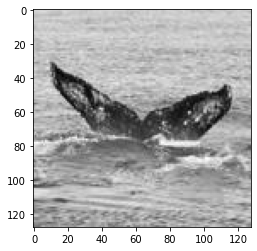

In [ ]:
plt.imshow(train_images[250], cmap = 'gray')
train_labels[250]

In [ ]:
#turning train data lists --> reshaped and normalized np.arrays

train_images = np.reshape(np.array(train_images), (len(train_images), 128, 128, 1)) / 255
train_labels = np.reshape(np.array(train_labels), (len(train_labels), 1))

train_images.shape, train_labels.shape

((13840, 128, 128, 1), (13840, 1))

In [ ]:
#function for shuffling data

def shuffle_in_unison(a, b):
    n_elem = a.shape[0]
    indeces = np.random.choice(n_elem, size=n_elem, replace=False)
    return a[indeces], b[indeces]

train_images_sh, train_labels_sh = shuffle_in_unison(train_images, train_labels)

del train_images
del train_labels

train_images_sh.shape, train_labels_sh.shape

((13840, 128, 128, 1), (13840, 1))

In [ ]:
random.seed(0)
#creating similar pairs

uniques = np.unique(train_labels_sh) #array of unique labels
print(len(np.unique(train_labels_sh, return_counts = True)[0]))

similar_X = []
similar_Y = []

for el in uniques:
    index = np.where(train_labels_sh == el)[0] #getting indexes of each unique in train_labels_sh

    if len(index) == 1:
        pair = []
        image_one = train_images_sh[index[0]]
        image_two = train_images_sh[index[0]]
        pair.append(image_one)
        pair.append(image_two)
        similar_X.append(pair)
        similar_Y.append(1)
    else:
        for i in range(0,len(index), 2): #6 because there are 6 images of each label
            pair = []
            image_one = train_images_sh[index[i]]
            image_two = train_images_sh[index[min(i+1, len(index)-1)]]
            pair.append(image_one)
            pair.append(image_two)
            similar_X.append(pair)
            similar_Y.append(1)

similar_X = np.array(similar_X)
similar_Y = np.array(similar_Y)

#creating different pairs

different_X = []
different_Y = []

#help_list = list(range(int(len(train_images_sh)/2), int(len(train_images_sh)))) #help list to get images from the second half

for i in range(int(len(train_images_sh)/2)): #looping through the first half of the train mages
    pair = []
    image_one = train_images_sh[i]
    #random_no = random.choice(help_list)
    random_no = random.randint(int(len(train_images_sh)/2), int(len(train_images_sh))-1)
    image_two = train_images_sh[random_no]
    if train_labels_sh[i] == train_labels_sh[random_no]: #if labels match, goes back to find a new one
        i = i - 1
        pass
    pair.append(image_one)
    pair.append(image_two)
    different_X.append(pair)
    different_Y.append(0) 
    #help_list.remove(random_no)

different_X = np.array(different_X)
different_Y = np.array(different_Y)

del uniques
del train_images_sh
del train_labels_sh

similar_X.shape, different_X.shape, similar_Y.shape, different_Y.shape

5004


((8514, 2, 128, 128, 1), (6920, 2, 128, 128, 1), (8514,), (6920,))

In [ ]:
#shuffling similar and different data
#similar_X, similar_Y = shuffle_in_unison(similar_X, similar_Y)
#different_X, different_Y = shuffle_in_unison(different_X, different_Y)

#creating val set (10% of train set)
#val_X = np.concatenate((similar_X[int(len(similar_X)*0.9):], different_X[int(len(different_X)*0.9):]))
#val_Y = np.concatenate((similar_Y[int(len(similar_Y)*0.9):], different_Y[int(len(different_Y)*0.9):]))

#excluding val set from similar and different pairs
#similar_X, similar_Y = similar_X[:int(len(similar_X)*0.9)], similar_Y[:int(len(similar_Y)*0.9)]
#different_X, different_Y = different_X[:int(len(different_X)*0.9)], different_Y[:int(len(different_Y)*0.9)]

#turning similar and different pairs into one array
similar_X = np.concatenate((similar_X, different_X))
print("h")
similar_Y = np.reshape(np.concatenate((similar_Y, different_Y)), (len(similar_X), 1))
print("hi")
del different_X
del different_Y

similar_X, similar_Y = shuffle_in_unison(similar_X, similar_Y)
print("hii")
similar_X, val_X, similar_Y, val_Y = train_test_split(similar_X, similar_Y, test_size = 0.2, random_state = 1)
print("hiii")
val_Y = np.reshape(val_Y, (len(val_X), 1))
print("hiiii")
val_X, val_Y = shuffle_in_unison(val_X, val_Y)
print("hiiiii")
#reshaping labels for model
similar_Y = similar_Y.reshape((-1,1))
val_Y = val_Y.reshape((-1,1))

similar_X.shape, similar_Y.shape, val_X.shape, val_Y.shape

h
hi
hii
hiii
hiiii
hiiiii


((12347, 2, 128, 128, 1), (12347, 1), (3087, 2, 128, 128, 1), (3087, 1))

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


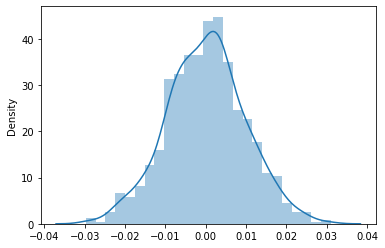

In [ ]:
#code taken from https://github.com/akshaysharma096/Siamese-Networks/blob/master/Few%20Shot%20Learning%20-%20V1.ipynb
#"The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
#suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01"

def initialize_weights(shape, dtype=None):
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

weights = initialize_weights((1000,1))
sns.distplot(weights)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


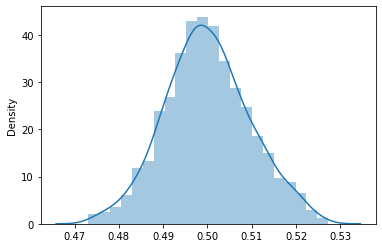

In [ ]:
#code taken from https://github.com/akshaysharma096/Siamese-Networks/blob/master/Few%20Shot%20Learning%20-%20V1.ipynb
#"The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
#suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01"

def initialize_bias(shape, dtype=None):
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

bias = initialize_bias((1000,1))
sns.distplot(bias)

In [ ]:
#defining branch and head model

def get_model(input_shape): 
    
    #branch model
    
    seq_model = Sequential()
    
    seq_model.add(Conv2D(64, (8,8), activation='relu', input_shape=input_shape,kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    seq_model.add(MaxPooling2D((2,2)))
    seq_model.add(BatchNormalization())
    
    seq_model.add(Conv2D(64, (4,4), activation='relu',kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4))) 
    seq_model.add(MaxPooling2D((1, 1)))
    seq_model.add(Dropout(0.1))
    seq_model.add(BatchNormalization())
    
    #seq_model.add(Conv2D(64, (1, 1), activation='relu',kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))   
    #seq_model.add(MaxPooling2D((1, 1)))
    #seq_model.add(BatchNormalization())
    
    #seq_model.add(Conv2D(64, (3,3), activation='relu',kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))    
    #seq_model.add(MaxPooling2D((1, 1)))   
    #seq_model.add(BatchNormalization())
    
    seq_model.add(Conv2D(128, (2,2), activation='relu',kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))    
    seq_model.add(MaxPooling2D((2,2))) 
    seq_model.add(Dropout(0.1))
    seq_model.add(BatchNormalization())
    
    seq_model.add(Conv2D(128, (2,2), activation='relu',kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))     
    seq_model.add(MaxPooling2D((2, 2)))
    seq_model.add(Dropout(0.2))
    seq_model.add(BatchNormalization())
    
    seq_model.add(Conv2D(256, (1,1), activation='relu',kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))  
    seq_model.add(MaxPooling2D((2,2)))
    seq_model.add(Dropout(0.2))
    seq_model.add(BatchNormalization())
    
    #seq_model.add(Conv2D(256, (1,1), activation='relu',kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))  
    #seq_model.add(BatchNormalization())
    
    #seq_model.add(Conv2D(512, (1,1), activation='relu')) 
    #seq_model.add(BatchNormalization())
    
    seq_model.add(GlobalMaxPooling2D())
    
    seq_model.add(Flatten())
    seq_model.add(Dense(5004, activation='sigmoid',kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4))) 
    
    print(seq_model.summary())
    #head model
    
    in1 = Input(input_shape)
    in2 = Input(input_shape)
    
    out_x1 = seq_model(in1)
    out_x2 = seq_model(in2)
    
    euc_dist = Lambda(lambda tensors:tensorflow.keras.backend.abs(tensors[0] - tensors[1]))([out_x1 , out_x2])
    
    outputs = Dense(1, activation = 'sigmoid', bias_initializer=initialize_bias)(euc_dist)
    
    snn = Model(inputs = [in1, in2], outputs = outputs)
    
    return snn

In [ ]:
datagen = ImageDataGenerator(width_shift_range=0.1,  # horizontally shift an image by a fraction of 0% - 10% (of original width)   
                 height_shift_range=0.1, # vertically shift an image by a fraction of 0% - 10% (of original height)   
                 horizontal_flip=True) # horizontaly flip random 30% of images 

# assign augmentation pipeline to our data
datagen.fit(similar_X[:,0])

In [ ]:
model= get_model((128, 128, 1))
model.compile(loss = 'binary_crossentropy', optimizer = Adam(lr=0.00005), metrics = ['accuracy'])
callback = EarlyStopping(patience = 5, monitor = 'val_loss', restore_best_weights = True)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 121, 121, 64)      4160      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 60, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 60, 60, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 57, 57, 64)        65600     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 57, 57, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 57, 57, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 57, 57, 64)        2

In [ ]:
history = model.fit_generator(datagen.flow(x = [similar_X[:,0], similar_X[:,1]], y = similar_Y, batch_size=32),
                              steps_per_epoch = similar_X.shape[0]//32,
                              epochs = 15, 
                              verbose = 1, 
                              validation_data = ([val_X[:,0], val_X[:,1]], val_Y)
                              )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/15
385/385 [==============================] - 19s 49ms/step - loss: 0.6576 - accuracy: 0.6530 - val_loss: 0.6703 - val_accuracy: 0.6476
Epoch 2/15
385/385 [==============================] - 19s 48ms/step - loss: 0.6326 - accuracy: 0.6758 - val_loss: 0.6374 - val_accuracy: 0.6910
Epoch 3/15
385/385 [==============================] - 18s 48ms/step - loss: 0.6154 - accuracy: 0.6883 - val_loss: 0.6272 - val_accuracy: 0.7078
Epoch 4/15
385/385 [==============================] - 19s 48ms/step - loss: 0.5948 - accuracy: 0.7030 - val_loss: 0.6085 - val_accuracy: 0.7272
Epoch 5/15
385/385 [==============================] - 19s 48ms/step - loss: 0.5706 - accuracy: 0.7207 - val_loss: 0.6050 - val_accuracy: 0.7324
Epoch 6/15
385/385 [==============================] - 19s 49ms/step - loss: 0.5497 - accuracy: 0.7354 - val_loss: 0.5846 - val_accuracy: 0.7470
Epoch 7/15
385/385 [==============================] - 18s 48

Text(0.5, 1.0, 'Accuracy')

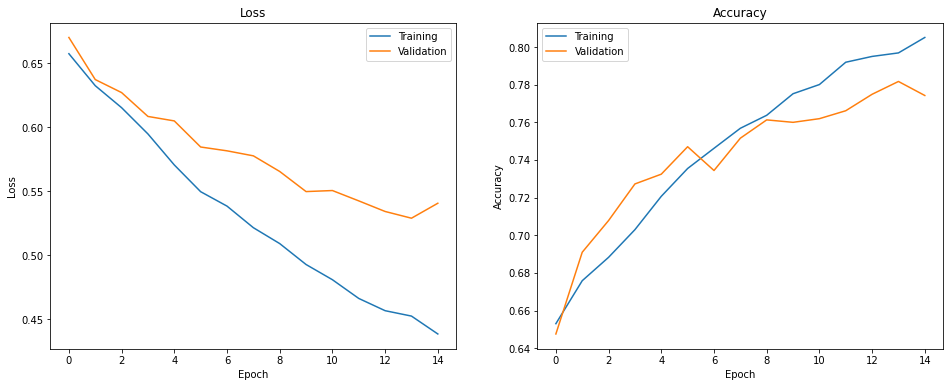

In [ ]:
#plot train and validation loss and accuracy (taken from ML HW 3)
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.title('Accuracy')

In [ ]:
!unzip /content/Drive/MyDrive/MachineLearning/test_resized_128.zip -d /Data/

Streaming output truncated to the last 5000 lines.
  inflating: /Data/test_resized_128/5edd0c9a0.jpg  
  inflating: /Data/test_resized_128/5ede343aa.jpg  
  inflating: /Data/test_resized_128/5edfb107a.jpg  
  inflating: /Data/test_resized_128/5eeec41d1.jpg  
  inflating: /Data/test_resized_128/5ef53e8e7.jpg  
  inflating: /Data/test_resized_128/5f020ae50.jpg  
  inflating: /Data/test_resized_128/5f225d380.jpg  
  inflating: /Data/test_resized_128/5f23e1d5d.jpg  
  inflating: /Data/test_resized_128/5f269b266.jpg  
  inflating: /Data/test_resized_128/5f33b1e7f.jpg  
  inflating: /Data/test_resized_128/5f4289116.jpg  
  inflating: /Data/test_resized_128/5f42dd618.jpg  
  inflating: /Data/test_resized_128/5f4665fbf.jpg  
  inflating: /Data/test_resized_128/5f49df8b9.jpg  
  inflating: /Data/test_resized_128/5f71b3295.jpg  
  inflating: /Data/test_resized_128/5f85ec4f6.jpg  
  inflating: /Data/test_resized_128/5f8c76fca.jpg  
  inflating: /Data/test_resized_128/5f93559ca.jpg  
  inflating: 

In [ ]:
#creating test images data set
test_csv = pd.read_csv("/Data/sample_submission.csv")
test_data = test_csv.values.tolist()

test_image_names = []
for el in test_data:
    img_name = el[0]
    test_image_names.append(img_name)

test_images = []
for img in test_image_names:
    f_name = r'/Data/test_resized_128/' + img
    test_image = np.asarray(Image.open(f_name))
    test_images.append(test_image)
        
test_images = np.reshape(np.array(test_images), (len(test_images), 128, 128, 1)) / 255
test_images.shape

(7960, 128, 128, 1)

In [ ]:
import heapq

def generate_training_samples():
  train_images = []
  train_labels = []
  for label in train_image_names.keys():
    img = train_image_names[label][0]
    f_name = r'/Data/train_resized_128/' + img
    train_image = np.asarray(Image.open(f_name))
    train_images.append(train_image)
    train_labels.append(label)

  train_images = np.reshape(np.array(train_images), (len(train_images), 128, 128, 1)) / 255
  train_labels = np.reshape(np.array(train_labels), (len(train_labels), 1))
  return train_images, train_labels
  
def gen_test(i, n, train_images, train_labels, labels, pairs):
  labels = []
  pairs = []
  test_image = test_images[i]
  for k in range(n):
    #ix = random.randint(0, len(train_images)-1)
    pair = []
    train_image = train_images[k]
    pair.append(test_image)
    pair.append(train_image)
    labels.append(train_labels[k])
    pairs.append(pair)
  pairs = np.array(pairs)
  labels = np.array(labels)
  return pairs, labels


number_of_elements = 5
all_predictions = []
labels = []
pairs = []
BATCH_SIZE = 512
train_images, train_labels = generate_training_samples()

#predictions = np.empty(len(train_images), dtype=np.float32)
predictions = []

BATCH_INDICES = np.arange(start=0, stop=len(train_images), step=BATCH_SIZE)  # row indices of batches
BATCH_INDICES = np.append(BATCH_INDICES, len(train_images))  # add final batch_end row
  
for pic in range(0, 10):  
  predict_pair, predict_label = gen_test(pic, len(train_images), train_images, train_labels, labels, pairs)
  for index in np.arange(len(BATCH_INDICES) - 1):
    batch_start = BATCH_INDICES[index]  # first row of the batch
    batch_end = BATCH_INDICES[index + 1]  # last row of the batch
    #print((predict_pair[batch_start:batch_end,1]).shape)
    predictions[batch_start:batch_end] = model.predict_on_batch([predict_pair[batch_start:batch_end,0], predict_pair[batch_start:batch_end,1]])

  #print(predictions)
  five_best_label_index = np.argsort(predictions, axis = 0)[-5:]
  sorted_pred = heapq.nlargest(number_of_elements, predictions)
  all_predictions.append("{} {} {} {} {} {} {} {} {} {}".format(train_labels[five_best_label_index[0][0]][0], sorted_pred[0][0], train_labels[five_best_label_index[1][0]][0], sorted_pred[1][0],
                                                               train_labels[five_best_label_index[2][0]][0], sorted_pred[2][0], train_labels[five_best_label_index[3][0]][0], sorted_pred[3][0],
                                                                train_labels[five_best_label_index[4][0]][0], sorted_pred[4][0]))
  #print(all_predictions)
  print(pic, test_image_names[pic], train_labels[five_best_label_index[0][0]][0], sorted_pred[0][0], train_labels[five_best_label_index[1][0]][0], sorted_pred[1][0],
                                                                train_labels[five_best_label_index[2][0]][0], sorted_pred[2][0], train_labels[five_best_label_index[3][0]][0], sorted_pred[3][0],
                                                                train_labels[five_best_label_index[4][0]][0], sorted_pred[4][0])
  
  #del predict_pair
  #del predict_label
  #del predictions 
  #del five_best_label_index
  #del sorted_pred



submission = pd.DataFrame(
    {'Image': test_image_names[0:10], 'Id': all_predictions},
    columns = ['Image', 'Id'])
submission.to_csv('submission_baseline.csv', index = False)

0 00028a005.jpg w_702b2c4 0.81835437 w_5c028f2 0.808116 w_5d438a9 0.7817575 w_5d1c9eb 0.7716835 w_3f44881 0.7700864
1 000dcf7d8.jpg w_6dfc3f1 0.80050826 w_c0c5cae 0.77952164 w_671b041 0.7752382 w_3137898 0.7561908 w_7ad1459 0.72989625
2 000e7c7df.jpg w_502e72f 0.8609114 w_9ca67be 0.8265183 w_082f603 0.82499486 w_1483be2 0.82357943 w_010f858 0.8162173
3 0019c34f4.jpg w_f7234f1 0.8204292 w_bbe79c3 0.809312 w_6fd8b4b 0.8069181 w_57437ee 0.7936723 w_28d57ec 0.78654635
4 001a4d292.jpg w_8b84ad0 0.85072714 w_750f1c8 0.84524757 w_0e2b483 0.8429187 w_1baf8df 0.8387051 w_6840783 0.83341396
5 00247bc36.jpg w_b950c88 0.8065578 w_13edc47 0.80511636 w_ba668da 0.7944656 w_f00c99d 0.78307796 w_4d61be5 0.76466644
6 0027089a4.jpg w_a41147a 0.7877724 w_6ebed02 0.7034431 w_b708e98 0.6977091 w_dcd9088 0.6856211 w_61e4690 0.65485567
7 002de4d94.jpg w_2c3768d 0.82547635 w_944ac4f 0.8169121 w_69c06ad 0.80851316 w_f6a16aa 0.8074859 w_1106cbb 0.80031997
8 002f52f0c.jpg w_0fe6fbb 0.786948 w_ad880b8 0.785394 w_5

In [ ]:
import heapq

def generate_training_samples():
  train_images = []
  train_labels = []
  for label in train_image_names.keys():
    img = train_image_names[label][0]
    f_name = r'/Data/train_resized_128/' + img
    train_image = np.asarray(Image.open(f_name))
    train_images.append(train_image)
    train_labels.append(label)

  train_images = np.reshape(np.array(train_images), (len(train_images), 128, 128, 1)) / 255
  train_labels = np.reshape(np.array(train_labels), (len(train_labels), 1))
  return train_images, train_labels
  
def gen_test(i, start, end, train_images, train_labels, labels, pairs):
  labels = []
  pairs = []
  test_image = test_images[i]
  for k in range(start, end):
    #ix = random.randint(0, len(train_images)-1)
    pair = []
    train_image = train_images[k]
    pair.append(test_image)
    pair.append(train_image)
    labels.append(train_labels[k])
    pairs.append(pair)
  pairs = np.array(pairs)
  labels = np.array(labels)
  return pairs, labels


number_of_elements = 5
all_predictions = []
labels = []
pairs = []
BATCH_SIZE = 512
train_images, train_labels = generate_training_samples()

predictions = []

BATCH_INDICES_PART1 = np.arange(start=0, stop=int(len(train_images)/2), step=BATCH_SIZE)  # row indices of batches
BATCH_INDICES_PART1 = np.append(BATCH_INDICES_PART1, int(len(train_images)/2))  # add final batch_end row

BATCH_INDICES_PART2 = np.arange(start=int(len(train_images)/2), stop=len(train_images), step=BATCH_SIZE)
BATCH_INDICES_PART2 = np.append(BATCH_INDICES_PART2, len(train_images))  # add final batch_end row
  
for pic in range(0, 7960):  
  predict_pair, predict_label = gen_test(pic, 0, int(len(train_images)/2), train_images, train_labels, labels, pairs)
  for index in np.arange(len(BATCH_INDICES_PART1) - 1):
    batch_start = BATCH_INDICES_PART1[index]  # first row of the batch
    batch_end = BATCH_INDICES_PART1[index + 1]  # last row of the batch
    #print((predict_pair[batch_start:batch_end,1]).shape)
    predictions[batch_start:batch_end] = model.predict_on_batch([predict_pair[batch_start:batch_end,0], predict_pair[batch_start:batch_end,1]])


  predict_pair, predict_label = gen_test(pic, int(len(train_images)/2), len(train_images), train_images, train_labels, predict_label, predict_pair)
  for index in np.arange(len(BATCH_INDICES_PART2) - 1):
    batch_start = BATCH_INDICES_PART2[index]  # first row of the batch
    batch_end = BATCH_INDICES_PART2[index + 1]  # last row of the batch
    #print((predict_pair[batch_start:batch_end,1]).shape)
    predictions[batch_start:batch_end] = model.predict_on_batch([predict_pair[(batch_start-int(len(train_images)/2)):(batch_end-int(len(train_images)/2)),0], predict_pair[(batch_start-int(len(train_images)/2)):(batch_end-int(len(train_images)/2)),1]])
  
  #print(predictions)
  five_best_label_index = np.argsort(predictions, axis = 0)[-5:]
  sorted_pred = heapq.nlargest(number_of_elements, predictions)
  all_predictions.append("{} {} {} {} {} {} {} {} {} {}".format(train_labels[five_best_label_index[0][0]][0], sorted_pred[0][0], train_labels[five_best_label_index[1][0]][0], sorted_pred[1][0],
                                                               train_labels[five_best_label_index[2][0]][0], sorted_pred[2][0], train_labels[five_best_label_index[3][0]][0], sorted_pred[3][0],
                                                                train_labels[five_best_label_index[4][0]][0], sorted_pred[4][0]))
  #print(all_predictions)
  print(pic, test_image_names[pic], train_labels[five_best_label_index[0][0]][0], sorted_pred[0][0], train_labels[five_best_label_index[1][0]][0], sorted_pred[1][0],
                                                                train_labels[five_best_label_index[2][0]][0], sorted_pred[2][0], train_labels[five_best_label_index[3][0]][0], sorted_pred[3][0],
                                                                train_labels[five_best_label_index[4][0]][0], sorted_pred[4][0])
  
  #del predict_pair
  #del predict_label
  #del predictions 
  #del five_best_label_index
  #del sorted_pred



submission = pd.DataFrame(
    {'Image': test_image_names[0:7960], 'Id': all_predictions},
    columns = ['Image', 'Id'])
submission.to_csv('submission_baseline.csv', index = False)

0 00028a005.jpg w_702b2c4 0.8183545 w_5c028f2 0.808116 w_5d438a9 0.7817575 w_5d1c9eb 0.7716835 w_3f44881 0.7700864
1 000dcf7d8.jpg w_6dfc3f1 0.80050826 w_c0c5cae 0.77952164 w_671b041 0.7752382 w_3137898 0.7561908 w_7ad1459 0.7298962
2 000e7c7df.jpg w_502e72f 0.8609114 w_9ca67be 0.8265183 w_082f603 0.82499486 w_1483be2 0.82357943 w_010f858 0.8162173
3 0019c34f4.jpg w_f7234f1 0.8204292 w_bbe79c3 0.809312 w_6fd8b4b 0.8069181 w_57437ee 0.7936723 w_28d57ec 0.78654635
4 001a4d292.jpg w_8b84ad0 0.85072714 w_750f1c8 0.84524757 w_0e2b483 0.8429187 w_1baf8df 0.8387051 w_6840783 0.83341396
5 00247bc36.jpg w_b950c88 0.8065578 w_13edc47 0.80511636 w_ba668da 0.7944656 w_f00c99d 0.78307796 w_4d61be5 0.76466644
6 0027089a4.jpg w_a41147a 0.7877724 w_6ebed02 0.7034431 w_b708e98 0.6977091 w_dcd9088 0.6856211 w_61e4690 0.65485567
7 002de4d94.jpg w_2c3768d 0.82547635 w_944ac4f 0.8169121 w_69c06ad 0.80851316 w_f6a16aa 0.8074859 w_1106cbb 0.80031997
8 002f52f0c.jpg w_0fe6fbb 0.786948 w_ad880b8 0.785394 w_51f